# Predicting ec50 of antagonistic mixtures from single-cell data.

Import general useful libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import time
from scipy.optimize import curve_fit

import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

Paths to different 'Mixed Antigen' datasets.

In [ ]:
# Small dataset:
# data_path = 'initialSingleCellDf-channel-20220808-MW_015.h5'

# Large dataset:
# data_path = 'initialSingleCellDf-channel-20220926-MW_020.h5'

# Batch-corrected dataset:
data_path = 'BatchCorrected_TCells_initialSingleCellDf-channel-20220808-MW_015.h5'

Extract 'Mixed Antigen' data and prepare helpful arrays.

In [ ]:
df = pd.read_hdf(data_path) # rows: different initial conditions/time points, columns: different markers
df = df.sort_index()
pd_idx = pd.IndexSlice # useful for intricate splicing
index_names = df.index.levels[:-1]

Time series of specific marker in specific condition of raw data. All ratios plotted separately.

In [ ]:
# Plot mean count over 4 time points for a specific cell type, antigen 1 and 2, and one marker
def marker_timeseries(df, celltype_str, antigen1_str, antigen2_str, marker_idx):
    '''
    celltype_str: 'PMEL', 'PMEL_APC', 'OT-1', 'OT-1_APC'
    antigen1_str: 'hgp100', 'mgp100', 'null'
    antigen2_str: 'N4', 'Q4', 'V4', 'null'
    '''

    timeseries_arr = np.empty((len(index_names[3]), len(index_names[4]))) # ratio x times

    for i in range(len(index_names[3])): # ratios
        for j in range(len(index_names[4])): # times
            timeseries_arr[i,j] = df.loc[celltype_str, antigen1_str, antigen2_str, index_names[3][i], index_names[4][j]].mean()[marker_idx]
        plt.plot(index_names[4], timeseries_arr[i,:], label = index_names[3][i])


    plt.title(celltype_str + ', ' + 'A1: ' + antigen1_str + ', ' + 'A2: ' + antigen2_str + ', ' + df.columns[marker_idx], fontsize = 14)
    plt.xlabel('Time (hrs)', fontsize = 14)
    plt.ylabel('MFI', fontsize = 14)
    plt.legend()
    plt.show()
    return timeseries_arr

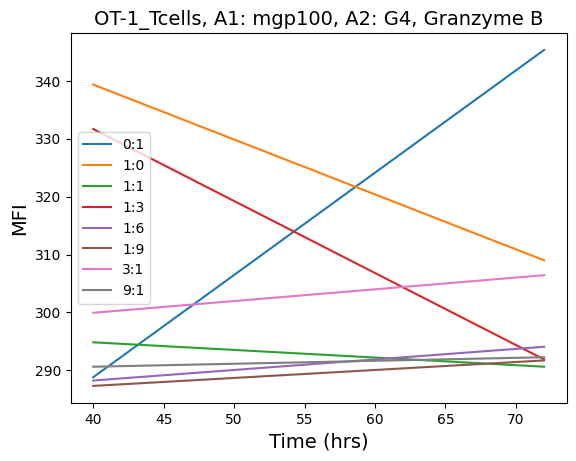

In [ ]:
timeseries = marker_timeseries(df, 'OT-1_Tcells', 'mgp100', 'G4', 5)

Marker as a function of ratio at a specific time snapshot.

In [ ]:
# Can investigate proliferation as a function of ratio, for example
def time_snapshot(df, celltype_str, antigen1_str, time_float, marker_idx):
    '''
    celltype_str: 'PMEL', 'PMEL_APC', 'OT-1', 'OT-1_APC'
    antigen1_str: 'hgp100', 'mgp100', 'null'
    time_float: 24., 36., 48., 72.
    '''
    ratios_arr = ['1:0', '9:1', '3:1', '1:1', '1:3', '1:6', '1:9', '0:1'] # manual to control order
    prolif_arr = np.empty((len(index_names[2]), len(ratios_arr))) # antigen 2 x ratios

    for i in range(len(index_names[2])): # antigen 2
        for j in range(len(ratios_arr)): # ratio
            prolif_arr[i,j] = df.loc[celltype_str, antigen1_str, index_names[2][i], ratios_arr[j], time_float].mean()[marker_idx]
        plt.plot(ratios_arr, prolif_arr[i,:], label = index_names[2][i])

    plt.title(celltype_str + ', ' + 'A1: ' + antigen1_str + ', ' + df.columns[marker_idx] + ', ' + 'Time: ' + str(time_float), fontsize = 14)
    plt.xlabel('PMEL:OT-1', fontsize = 14)
    plt.ylabel('MFI', fontsize = 14)
    plt.legend(title = 'Antigen 2')
    plt.show()
    return prolif_arr

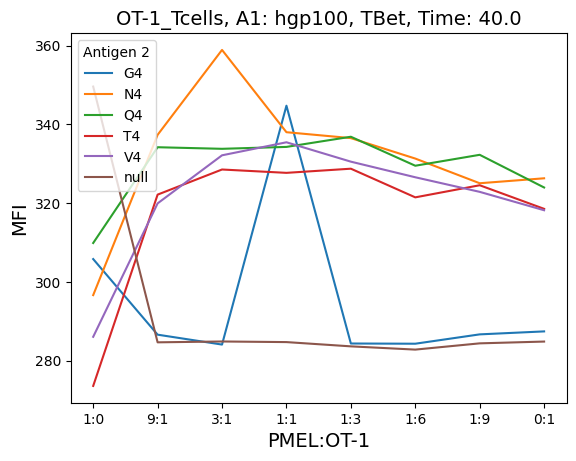

In [ ]:
prolif = time_snapshot(df, 'OT-1_Tcells', 'hgp100', 40., 16)

# Quantifying response from dose-response curves (Sooraj's data).

We want to quantify antigenicity of unmixed antigens so that we can make a naive guess about what antigenicity their mixtures will have. The integral of dose-response curves is a good measure of the response an antigen induces.

A lot of the code in this section is copied from Sooraj and Francois' Colab file.

To avoid the hassel of getting Google Drive access, you can skip this section by just running the block below which gives you the response and colour dictionaries - the only two variables needed from this part.

In [ ]:
# response_dict = {'G4': 4.388740954144362, 'N4': 132.65244018914316, 'Q4': 82.55816054949247, 'T4': 45.32451203659729, 'V4': 13.853149517019041, 'hgp100': 104.73625490477923, 'mgp100': 18.92603236006396}
# colour_dict = {'G4': '#1f77b4', 'N4': '#ff7f0e', 'Q4': '#2ca02c', 'T4': '#d62728', 'V4': '#9467bd', 'hgp100': '#8c564b', 'mgp100': '#e377c2'}

Libraries for importing 'Dose-response' dataset from Google Drive.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive as outputDrive

Get access to Google Drive.

In [ ]:
# If on Google Colab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

outputDrive.mount('/content/gdrive', force_remount=True)

# Path to the folder:
root_dir = "/content/gdrive/My Drive/McGill_NCI Collaboration/"
base_dir = root_dir + 'Figures/version2/supplemental/'

#If local
#base_dir = ''

Mounted at /content/gdrive


Import 'Dose-response' dataset from Google Drive.

In [ ]:
def createClusterFrequencyDataframe(singleCellDf,cluster_labels=[]):
    clusterdf = singleCellDf.assign(Cluster=cluster_labels).set_index('Cluster', append=True).droplevel('Event')
    indexingDf = clusterdf.groupby(list(singleCellDf.index.names)[:-1]).first()
    newdfTuples = []
    newDataMatrixList = []
    newDataMatrixList2 = []
    clusterOrder = []
    clusterDictKeys = list(clusterdf.index.unique('Cluster'))
    clusterDictKeys.sort(key=int)
    emptyClusterDict = {}

    for clusterKey in clusterDictKeys:
        emptyClusterDict[clusterKey] = 0
    for row in range(indexingDf.shape[0]):
        index = indexingDf.iloc[row,:].name
        #Percent
        sampleDf = clusterdf.loc[index].index.get_level_values('Cluster').value_counts(normalize=True).mul(100).T
        #Count
        sampleDf2 = clusterdf.loc[index].index.get_level_values('Cluster').value_counts().T
        clusterDict = emptyClusterDict.copy()
        clusterDict2 = emptyClusterDict.copy()
        cvals = []
        cvals2 = []
        for clusterKey in sampleDf.index:
            clusterDict[clusterKey] = sampleDf.loc[clusterKey]
        for clusterKey2 in sampleDf2.index:
            clusterDict2[clusterKey2] = sampleDf2.loc[clusterKey2]
        newDataMatrixList.append(list(clusterDict.values()))
        newDataMatrixList2.append(list(clusterDict2.values()))
        newdfTuples.append(list(index))

    newDataMatrix = np.vstack(newDataMatrixList)
    newDataMatrix2 = np.vstack(newDataMatrixList2)
    mi = pd.MultiIndex.from_tuples(newdfTuples,names=indexingDf.index.names)
    percentdf = pd.DataFrame(newDataMatrix,index=mi,columns=list(clusterDict.keys()))
    countdf = pd.DataFrame(newDataMatrix2,index=mi,columns=list(clusterDict.keys()))

    frequencydf = pd.concat([percentdf,countdf],keys=['percent','count'],names=['Statistic']).swaplevel(0,1)
    frequencydf.columns.name = 'Cluster'
    return frequencydf

In [ ]:
scDimRedDf = pd.read_hdf(base_dir+'data/initialSingleCellDf-channel-20200909-BlastActivationMultipleTCR_1-reduced-umap.hdf',key='df')
scClusterLabels = np.load(base_dir+'data/initialSingleCellDf-channel-20200909-BlastActivationMultipleTCR_1-clustered-phenograph.npy')
scDimRedDf['Label'] = scClusterLabels
scDimRedDf = scDimRedDf.sort_index()
clusterFrequencyDf = createClusterFrequencyDataframe(scDimRedDf[scDimRedDf.columns[:-1]],cluster_labels=scDimRedDf['Label'])

Function for converting string concentrations into floats (M).

In [ ]:
import itertools

def SI_to_float(conc_str, replacement_zero = 1e-13): # copying replacement zero of Sooraj and Francois
  SI = {'f':1e-15,'p':1e-12,'n':1e-9,'u':1e-6,'m':1e-3,'':1e0,'k':1e3}
  if conc_str == '0':
    return replacement_zero
  else:
    split = [''.join(x) for _, x in itertools.groupby(conc_str, key=str.isdigit)]
  return int(split[0])*SI[split[1][0]]

Defining the Hill function for fitting.

In [ ]:
def Hill(x, A, EC, n, baseline):
  return A*np.power(x,n)/(np.power(EC,n) + np.power(x,n)) + baseline

Fit Hill functions onto Sooraj's data.

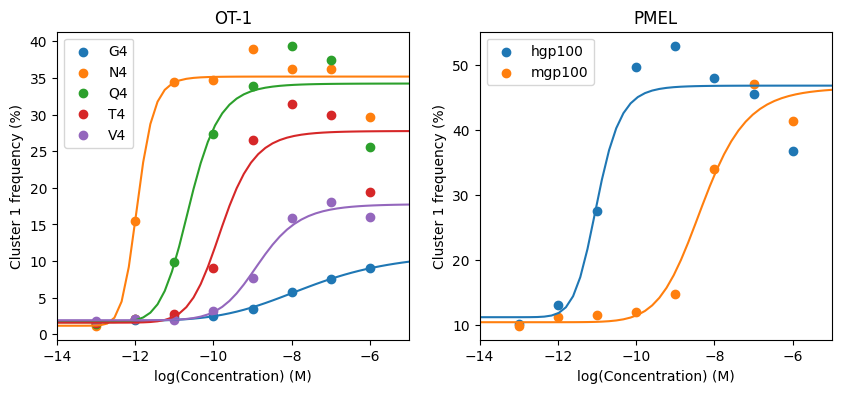

In [ ]:
_, ax = plt.subplots(1, 2, figsize = (10, 4))

param_arr = np.empty((np.sum(index_names[1] != 'null') + np.sum(index_names[2] != 'null'), 4))
antigen_list = []

for i, TCR in enumerate(['OT1', 'PMEL']):
  for j, peptide in enumerate(index_names[int(2/(i + 1))]):
    if peptide in clusterFrequencyDf.index.get_level_values(3):
      antigen_list.append(peptide)
      freqs = clusterFrequencyDf.loc[pd_idx[:, 'percent', TCR, peptide,:,:], 1]
      concs = np.log10([SI_to_float(c) for c in freqs.index.get_level_values(4)])
      indices = np.argsort(concs)
      freqs = np.array(freqs)[indices]
      concs = np.array(concs)[indices]
      ax[i].scatter(concs, freqs, label = peptide)

      # Fit curve
      shift = -1*min(concs) + 1
      x_max = max(concs) + 1
      concs = concs + shift # this ensures all values are positive... may help with overflow
      lowerCurveFitBounds = [(np.max(freqs)-np.min(freqs))*0.5,0,0, 0]
      upperCurveFitBounds = [(np.max(freqs)-np.min(freqs))*2, np.max(concs)*10, 10, np.min(freqs)*2]
      popt, pcov = curve_fit(Hill, concs, freqs, bounds = [lowerCurveFitBounds, upperCurveFitBounds])
      param_arr[5*i + j,:] = popt

      xlims = [-1*shift, x_max]
      x_fit = np.linspace(xlims[0], xlims[1], 50) + shift
      ax[i].plot(x_fit - shift, Hill(x_fit, *popt))

  ax[i].set_title(['OT-1', 'PMEL'][i])
  ax[i].set_xlabel('log(Concentration) (M)')
  ax[i].set_ylabel('Cluster 1 frequency (%)')
  ax[i].set_xlim(xlims)
  ax[i].legend()
plt.show()

Now, using the parameters, we can quantify overall response by integrating each Hill function from negative infinity to 10 M, the concentration at which all of the antigens have plateaued.

{'G4': 4.388740954144362, 'N4': 132.65244018914316, 'Q4': 82.55816054949247, 'T4': 45.32451203659729, 'V4': 13.853149517019041, 'hgp100': 104.73625490477923, 'mgp100': 18.92603236006396}


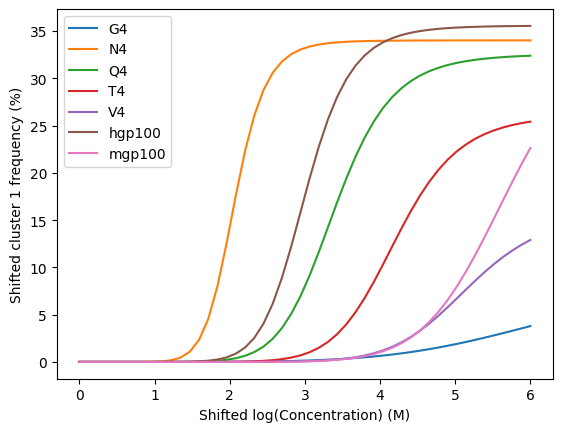

In [ ]:
import scipy.integrate

response_dict = {}
colour_dict = {}
for i in range(len(antigen_list)):
  x_fit = np.linspace(xlims[0], -8, 50) + shift # integrating until realistic concentration of host
  p = plt.plot(x_fit, Hill(x_fit, param_arr[i,0], param_arr[i,1], param_arr[i,2], 0), label = antigen_list[i]) # make sure integration is over reasonable range
  plt.xlabel('Shifted log(Concentration) (M)')
  plt.ylabel('Shifted cluster 1 frequency (%)')
  plt.legend()

  response = scipy.integrate.quad(Hill, 0, 6, args = (param_arr[i,0], param_arr[i,1], param_arr[i,2], 0))
  response_dict[antigen_list[i]] = response[0]
  colour_dict[antigen_list[i]] = p[0].get_color()
print(response_dict)

Preprocess dataframe by adding linear combination of antigen responsiveness as labels and omitting noisy data.

In [ ]:
def get_quality(key_arr):
    return np.array([response_dict[key] for key in key_arr])

# Omits specified data and adds column with linear combination of ec50 as labels
def preprocess(df, omissions = None, standardize_unmixed = False):
    # omissions should be a M by 2 matrix with strings, ex. [['Antigen1', 'null'], ['Antigen2', 'null'], ['Antigen2', 'G4']]
    if isinstance(omissions, np.ndarray):
      for i in range(omissions.shape[0]):
        df = df[df.index.get_level_values(omissions[i,0]) != omissions[i,1]] # exclude rows with certain index value
    df2 = df.reset_index(level = ['Antigen1', 'Antigen2', 'Ratio'])
    ratio_arr = np.array([ratio.split(':') for ratio in df2['Ratio']]).astype(int) # N by 2
    df['Quality'] = (ratio_arr[:,0]*get_quality(df2['Antigen1']) + ratio_arr[:,1]*get_quality(df2['Antigen2']))/np.sum(ratio_arr, axis = 1)
    return df

In [ ]:
# These are re defined to make sure previously excluded values are back
df = pd.read_hdf(data_path) # rows: different initial conditions/time points, columns: different markers
df = df.sort_index()

omissions = np.array([['Antigen1', 'null'], ['Antigen2', 'null']])
df = preprocess(df, omissions)

unmixed_idx = (df.index.get_level_values(3) == '1:0')|(df.index.get_level_values(3) == '0:1')
df_unmixed = df[unmixed_idx]
df_mixed = df[~unmixed_idx]

Do a PCA of the unmixed dataset. This is done to reduce the dimensionality of the original dataset (by seeing which columns contribute least to the PCs).

In [ ]:
# Returns dimensionally reduced dataframe for better training
def principle(df_unmixed, df_mixed):
    pca = PCA(n_components = df_unmixed[df_unmixed.columns[:-1]].shape[1])
    pca.fit(df_unmixed[df_unmixed.columns[:-1]])

    cumul_variance = [pca.explained_variance_ratio_[0]]
    for i in range(1, len(pca.explained_variance_ratio_)):
        cumul_variance.append(pca.explained_variance_ratio_[i] + cumul_variance[i-1])
    plt.plot(range(1, df_unmixed.shape[1]), cumul_variance)
    plt.xlabel('# of components', fontsize = 14)
    plt.ylabel('Cumulative explained variance', fontsize = 14)
    plt.axhline(y = 0.9, linestyle = '--', color = 'k')
    plt.show()

    # The number of components at which > 90% of variance is explained..
    min_pc = np.where(np.array(cumul_variance) > 0.9)[0][0] + 1

    print(f'> 90% of the variance is explained by {min_pc} principle component(s).')

    columns_df=[f'PC{i}' for i in range(min_pc)]
    map_df = pd.DataFrame(pca.components_[:min_pc].T, columns = columns_df, index = df_unmixed[df_unmixed.columns[:-1]].columns)
    plt.figure(figsize=(12,12))
    sns.heatmap(map_df, cmap = 'magma')

    contribs = map_df.abs().sum(axis = 1)
    thresh = 0.5 # arbitrary, but only excludes 3 columns

    # Drop features that do not contribute much to variance
    df_unmixed = df_unmixed.drop(contribs.index[contribs < thresh], axis = 1)
    df_mixed = df_mixed.drop(contribs.index[contribs < thresh], axis = 1)

    return df_unmixed, df_mixed

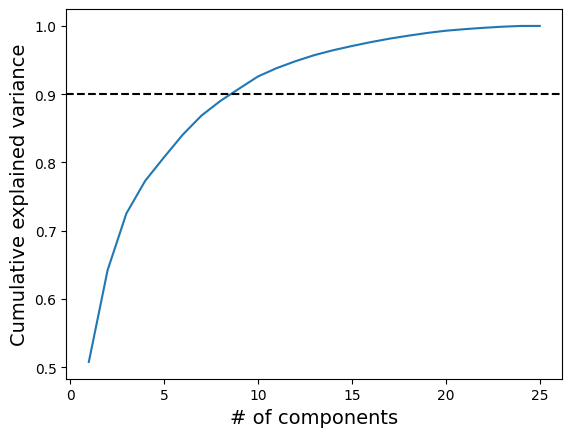

> 90% of the variance is explained by 9 principle component(s).


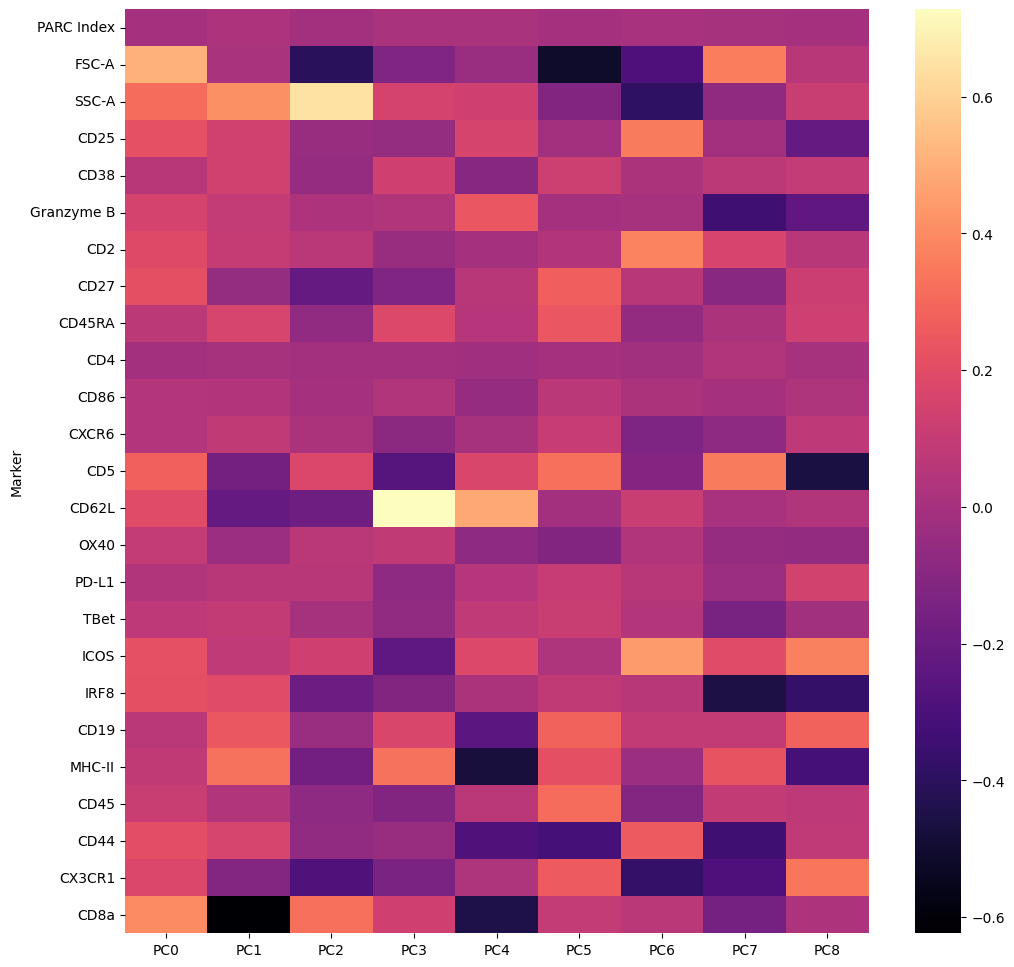

In [ ]:
df_unmixed, df_mixed = principle(df_unmixed, df_mixed)

# Load or train regressor.

Option A: load previously trained regressor.

In [ ]:
name = 'n_est_200_depth_15_omit_null.txt'
boost = XGBRegressor()
boost.load_model(name)

_, X_unmixed, _, y_unmixed = train_test_split(df_unmixed[df_unmixed.columns[:-1]], df_unmixed['Quality'], test_size = 0.2, random_state = 23)

Option B: train new regressor.

Train the model on unmixed data and leave out some unmixed data to verify model is working properly on it. Function also returns a name for the saved model.

In [ ]:
def train_model(df_unmixed, omissions = None, n_est = 200, max_depth = 7, eta = 0.1, subsample = 0.7, colsample_bytree = 0.8):
  print('Make sure the dataframe is preprocessed!')

  X_train, X_unmixed_test, y_train, y_unmixed_test = train_test_split(df_unmixed[df_unmixed.columns[:-1]], df_unmixed['Quality'], test_size = 0.2, random_state = 23)

  boost = XGBRegressor(n_estimators = n_est, max_depth = max_depth, eta = eta, subsample = subsample, colsample_bytree = colsample_bytree)
  boost.fit(X_train, y_train)

  name = 'n_est_' + str(n_est) + '_depth_' + str(max_depth)
  if isinstance(omissions, np.ndarray):
    name += '_omit'
    omit_arr = np.unique(omissions[:,1])
    for omit in omit_arr:
      name += '_' + omit
  name += '.txt'

  return X_unmixed_test, y_unmixed_test, boost, name


In [ ]:
X_unmixed, y_unmixed, boost, name = train_model(df_unmixed, omissions, n_est = 100, max_depth = 15)

Make sure the dataframe is preprocessed!


Save model for future predictions.

In [ ]:
boost.save_model(name)

# Make and evaluate predictions.

Some metrics to evaluate the performance of the trained model.

In [ ]:
# Returns MSE
def evaluate_MSE(preds, y_test):
    err_sqrd = (preds - y_test)**2
    return err_sqrd.mean()

# Investigate accuracy by group
def MSE_by_group(preds, y_test):
    err_sqrd = (preds - y_test)**2
    print(err_sqrd.groupby('CellType').mean())
    print(err_sqrd.groupby('Antigen1').mean())
    print(err_sqrd.groupby('Antigen2').mean())
    print(err_sqrd.groupby('Ratio').mean())
    print(err_sqrd.groupby('Time').mean())
    return

In [ ]:
X_mixed = df_mixed[df_mixed.columns[:-1]]
y_mixed = df_mixed['Quality']
ordered_mixed_ratios = ['9:1', '3:1', '1:1', '1:3', '1:6', '1:9']

preds_unmixed = boost.predict(X_unmixed)
preds_mixed = boost.predict(X_mixed)

print('Unmixed MSE: ', round(evaluate_MSE(preds_unmixed, y_unmixed),3))
print('Mixed MSE: ', round(evaluate_MSE(preds_mixed, y_mixed),3))

Unmixed MSE:  746.121
Mixed MSE:  1204.373


In [ ]:
MSE_by_group(preds_unmixed, y_unmixed)

CellType
OT-1_APCs      1603.159807
OT-1_Tcells     703.408479
PMEL_APCs      1241.225691
PMEL_Tcells     600.898309
Name: Quality, dtype: float64
Antigen1
hgp100    659.203383
mgp100    936.020461
Name: Quality, dtype: float64
Antigen2
G4     792.515486
N4     966.276274
Q4     399.560399
T4     638.805381
V4    1126.903365
Name: Quality, dtype: float64
Ratio
0:1    917.790412
1:0    673.885818
Name: Quality, dtype: float64
Time
40.0    983.629213
72.0    514.119027
Name: Quality, dtype: float64


Visualize the correlation between naive and predicted responses.

In [ ]:
def correlation(preds, y):
    corr_df = y.to_frame()
    corr_df['Predictions'] = preds

    celltypes = corr_df.index.unique('CellType')
    x_arr = corr_df['Quality'].unique()
    mean_y_arr = np.empty((len(x_arr), len(celltypes)))
    std_y_arr = np.empty((len(x_arr), len(celltypes)))

    colour_arr = np.empty((len(x_arr), len(celltypes), 2)).astype(str) # 3rd dimension -> 0: left colour fill, 1: right colour fill

    for i, x in enumerate(x_arr):
      sub_df = corr_df[corr_df['Quality'] == x]
      for j, cell in enumerate(celltypes):
        cell_df = sub_df[sub_df.index.get_level_values('CellType') == cell]
        mean_y_arr[i,j] = cell_df['Predictions'].mean()
        std_y_arr[i,j] = cell_df['Predictions'].std()

        a1 = cell_df.index.get_level_values('Antigen1')[0]
        a2 = cell_df.index.get_level_values('Antigen2')[0]

        if cell_df.index.get_level_values('Ratio')[0][0] != '0':
          colour_arr[i,j,0] = colour_dict[a1]
        else:
          colour_arr[i,j,0] = colour_dict[a2]

        if cell_df.index.get_level_values('Ratio')[0][-1] != '0':
          colour_arr[i,j,1] = colour_dict[a2]
        else:
          colour_arr[i,j,1] = colour_dict[a1]
    return x_arr, mean_y_arr, std_y_arr, colour_arr

# Plot correlation of training and testing data
def plot_corr(naive_list, preds_list):

    celltypes = naive_list[0].index.unique('CellType') # assuming same for both lists, as it should be!
    _, ax = plt.subplots(3, len(celltypes) + 1, figsize = (12,7))

    buffer = 5
    for i in range(1,3):
      x, mean_y, std_y, colour_arr = correlation(preds_list[i-1], naive_list[i-1])
      for j in range(len(celltypes)):
        min_qual = min(min(x), np.min(mean_y[:,j]))
        max_qual = max(max(x), np.min(mean_y[:,j]))
        ax[i,j+1].set_xlim([min_qual - buffer, max_qual + buffer])
        ax[i,j+1].set_ylim([min_qual - buffer, max_qual + buffer])
        ax[i,j+1].axline([min_qual, min_qual], slope = 1, ls = '--', color = 'grey')
        ax[i,j+1].errorbar(x, mean_y[:,j], yerr = std_y[:,j], linestyle = '', capsize = 5, color = 'grey', alpha = 0.2)
        ax[i,j+1].scatter(x, mean_y[:,j], c = colour_arr[:,j,0], marker = MarkerStyle('o', fillstyle = 'left'))
        ax[i,j+1].scatter(x, mean_y[:,j], c = colour_arr[:,j,1], marker = MarkerStyle('o', fillstyle = 'right'))
        ax[i,j+1].set_title(f'$r^2 = ${round((np.corrcoef(x, mean_y[:,j])[0,1])**2,3)}')
        if i == 2: # set x labels
          ax[i,j].set_xlabel('Naive quality', fontsize = 14)
          ax[0,j].axis('off') # only in this if statement to only run once
          ax[0,j+1].text(0, 0.5, celltypes[j], fontsize = 16) # set cell type labels
      ax[i,0].axis('off')
      ax[i,0].text(0, 0.5, ['Unmixed', 'Mixed'][i-1], fontsize = 16)
      ax[i,1].set_ylabel('Predicted quality', fontsize = 14)

    handles = [plt.Line2D([], [], color=colour_dict[label], marker = 'o', linestyle = '') for label in colour_dict] # invisible plot to define marker and colour
    ax[0,0].legend(handles, list(colour_dict.keys()))
    ax[0,-1].axis('off')


    plt.tight_layout()
    plt.show()
    return

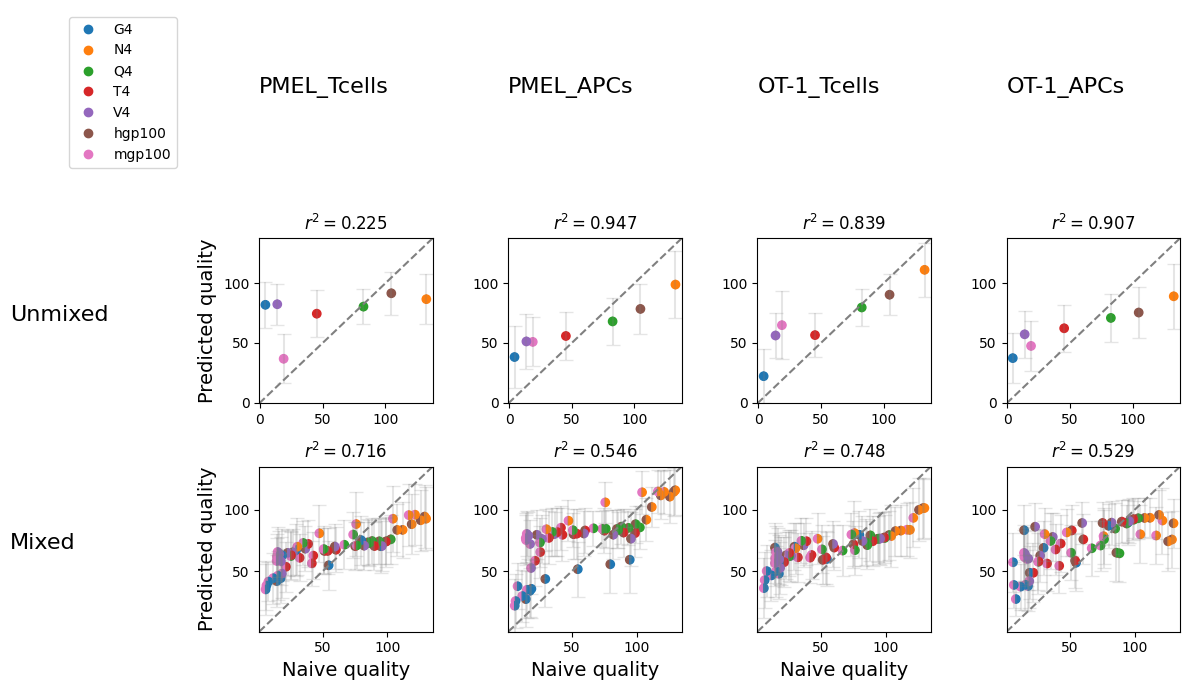

In [ ]:
plot_corr([y_unmixed, y_mixed], [preds_unmixed, preds_mixed])

In [ ]:
def deviance_3D(y, preds):
    corr_df = y.to_frame().droplevel('Event')
    corr_df['Predictions'] = preds
    corr_df['Mean'] = corr_df['Predictions'].groupby(corr_df['Quality']).transform('mean')
    corr_df['Std'] = corr_df['Predictions'].groupby(corr_df['Quality']).transform('std')
    corr_df = corr_df.drop_duplicates(subset = 'Quality')
    corr_df = corr_df.drop('Predictions', axis = 1)
    corr_df['Deviance'] = corr_df['Mean'] - corr_df['Quality'] # vertical distance to correlation line

    _, ax = plt.subplots(len(corr_df.index.unique('Antigen1')), len(corr_df.index.unique('Antigen2')) + 1, figsize = (12,5))
    for i, a1 in enumerate(corr_df.index.unique('Antigen1')):
      ax[i, 0].text(0.25, 0.5, a1, fontsize = 16)
      ax[i,0].axis('off')
      for j, a2 in enumerate(corr_df.index.unique('Antigen2')):
        ax[i,j + 1].scatter(ordered_mixed_ratios, corr_df.loc[pd_idx[:, a1, a2, ordered_mixed_ratios,:],'Deviance'])
        if i == 0:
            ax[i,j + 1].set_title(a2, fontsize = 16)
        elif i == len(corr_df.index.unique('Antigen1')) - 1: # being very general here
            ax[i,j + 1].set_xlabel('Ratio', fontsize = 14)
        if j == 1:
            ax[i,j].set_ylabel('Deviance', fontsize = 14)
    plt.tight_layout()
    plt.show()
    return

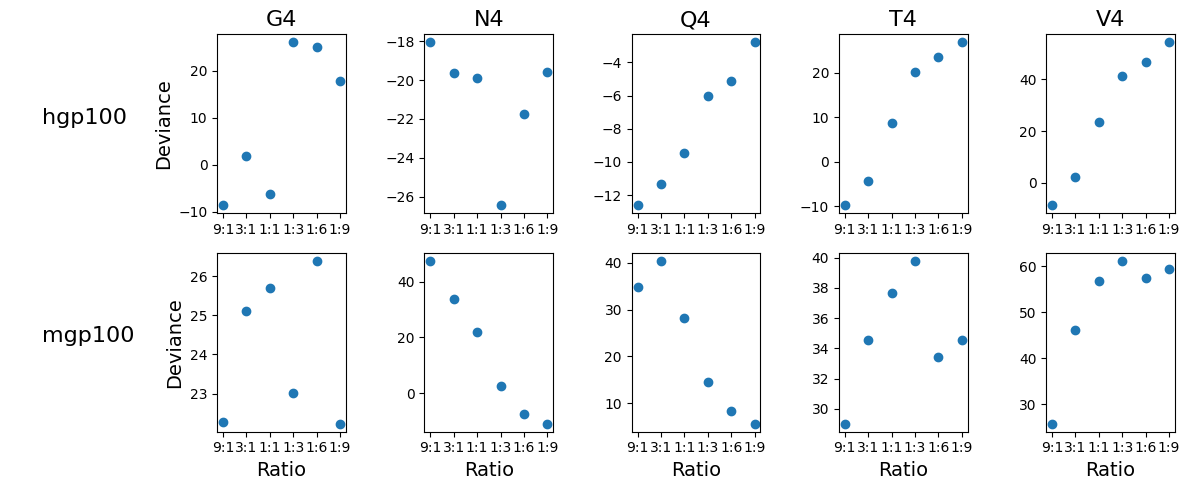

In [ ]:
deviance_3D(y_mixed, preds_mixed)

The ratio of predicted quality to naive quality should give us a measure of whether the mixed antigens are antagonizing or synergizing.

In [ ]:
# Antagonism as a function of ratio with diff. lines for diff. A2 and diff. for given A1.

def antag_vs_ratio(preds, y_test, a1_str, ratio_arr):
    # make sure ratio is appropriate for preds and y_test
    # also, order them properly

    antag = preds - y_test # subtract because they are in log-scale

    mean_y_arr = np.empty(len(ratio_arr))
    std_y_arr = np.empty(len(ratio_arr))

    plt.figure(figsize = (8, 5))

    for a2_str in y_test.index.unique('Antigen2'):
        for i, ratio_str in enumerate(ratio_arr):
            mean_y_arr[i] = antag.loc[pd_idx[:, a1_str, a2_str, ratio_str,:,:]].mean()
            std_y_arr[i] = antag.loc[pd_idx[:, a1_str, a2_str, ratio_str,:,:]].std()
        plt.errorbar(ratio_arr, mean_y_arr, yerr = std_y_arr, color = colour_dict[a2_str], capsize = 5, marker = 'o', label = a2_str)

    plt.axhline(y = 0, ls = '--', color = 'grey')
    plt.xlabel('Ratio', fontsize = 14)
    plt.ylabel('log(Predicted quality/naive quality)', fontsize = 14)
    plt.title(f'{a1_str}')
    plt.legend(title = 'OT-1 Antigen')
    plt.tight_layout()
    plt.show()
    return

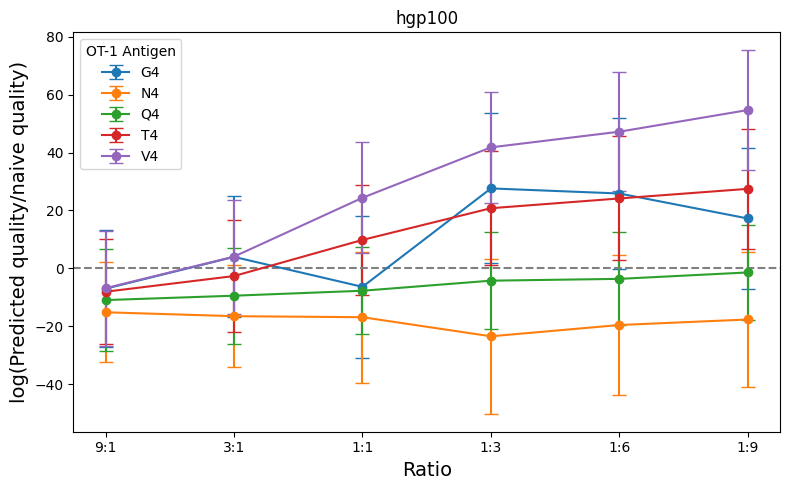

In [ ]:
ordered_mixed_ratios = ['9:1', '3:1', '1:1', '1:3', '1:6', '1:9']
antag_vs_ratio(preds_mixed, y_mixed, 'hgp100', ordered_mixed_ratios)

# Hyper-parameter tuning.

Import libraries useful for tuning hyperparameters.

In [ ]:
import hyperopt
from hyperopt import fmin, hp
import xgboost

In [ ]:
space = {'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
         'eta': hp.quniform('eta', 0.025, 1, 0.05),
         'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
         'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         }

In [ ]:
def objective(xgb_params):
    print("Training with params: ")
    print(xgb_params)
    num_round = int(xgb_params['n_estimators'])
    del xgb_params['n_estimators']
    model = xgboost.train(xgb_params, dataloader, num_round, evals = dataset,
                      early_stopping_rounds=10, verbose_eval=True)
    predictions = model.predict(datatest, iteration_range=(0, model.best_iteration + 1))
    test_acc = metrics.accuracy_score(y_test, np.argmax(predictions, axis=1))
    loss = 1 - test_acc
    avg_per_class_acc = metrics.balanced_accuracy_score(y_test, np.argmax(predictions, axis=1))
    print('Test, test acc: %.6f, test avg acc: %.6f, loss: %.6f' % (test_acc, avg_per_class_acc, loss))
    return {'loss': loss, 'status': STATUS_OK, 'model': model }